In [1]:
import math

import numpy as np
import argparse
import time
from multiprocessing import Pool, TimeoutError

In [2]:
def compute_julia_set_sequential(*args):
    try:
        if type(args) == tuple and len(args[0]) == 6:
            xmin, xmax, ymin, ymax, im_width, im_height = args[0]
        else:
            raise TypeError(f"compute_julia_set_sequential takes 6 arguments but {len(args)} were given")

    except:
        pass
    zabs_max = 10
    c = complex(-0.1, 0.65)
    nit_max = 1000

    xwidth = xmax - xmin
    yheight = ymax - ymin

    julia = np.zeros((im_width, im_height))
    for ix in range(im_width):
        for iy in range(im_height):
            nit = 0
            # Map pixel position to a point in the complex plane
            z = complex(ix / im_width * xwidth + xmin,
                        iy / im_height * yheight + ymin)
            # Do the iterations
            while abs(z) <= zabs_max and nit < nit_max:
                z = z ** 2 + c
                nit += 1
            ratio = nit / nit_max
            julia[ix, iy] = ratio

    return julia

In [9]:
def task_generator(ymax, ymin, scaled_y, num_y_patches, xmax, xmin, scaled_x, num_x_patches, patch, size):
    tasks = list()
    patch_ymax = ymax
    patch_ymin = ymax - scaled_y
    for col in range(num_y_patches):
        patch_xmin = xmin
        patch_xmax = xmin + scaled_x
        if col + 1 == num_y_patches:
            ypatch_size = size - (num_y_patches - 1) * patch
        else:
            ypatch_size = patch

        for ridx in range(num_x_patches):
            if ridx + 1 == num_x_patches:
                xpatch_size = size - (num_x_patches - 1) * patch
            else:
                xpatch_size = patch
            tasks.append((patch_xmin, patch_xmax, patch_ymin, patch_ymax, xpatch_size, ypatch_size))
            patch_xmin = patch_xmax
            patch_xmax = xmax if (ridx + 2 == num_x_patches) else (patch_xmax + scaled_x)

        patch_ymax = patch_ymin
        patch_ymin = ymin if (col + 2 == num_y_patches) else (patch_ymin - scaled_y)

    return tasks

In [10]:
def compute_julia_in_parallel(size, xmin, xmax, ymin, ymax, patch, nprocs):
    pool = Pool(processes=nprocs)

    im_width = xmax - xmin
    im_height = ymax - ymin

    # patch size
    scaled_x = (im_width / size) * patch
    scaled_y = (im_height / size) * patch

    # patch number
    num_row_patches = math.ceil(im_width / scaled_x)
    num_col_patches = math.ceil(im_height / scaled_y)

    # task generator
    tasks = task_generator(ymax, ymin, scaled_y, num_col_patches,
                           xmax, xmin, scaled_x, num_row_patches,
                           patch, size)
#     print(tasks)
    compute_patches = pool.map(compute_julia_set_sequential, tasks, chunksize=1)
    pool.close()
    pool.join()
    
    row_patches = [
        np.concatenate(compute_patches[row-num_row_patches:row], axis=0)
        for row in range(num_row_patches,num_row_patches*num_col_patches+1, num_row_patches)
    ]
    julia_img = np.concatenate(list(row_patches[::-1]), axis=1)
#     julia_img = compute_julia_set_sequential(xmin, xmax, ymin, ymax, size, size)

    return julia_img

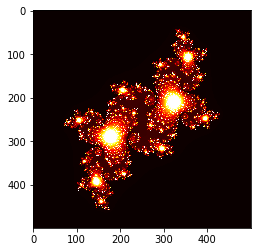

In [11]:
p = compute_julia_in_parallel(
    size = 500,
    xmin = -1.5,
    ymin = -1.5,
    xmax=1.5,
    ymax=1.5,
    patch=20,
    nprocs=6)



import matplotlib.pyplot as plt
import matplotlib.cm as cm
fig, ax = plt.subplots()
ax.imshow(p, interpolation='nearest', cmap=plt.get_cmap("hot"))
plt.show()